In [60]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [61]:
sns.set_context("paper")
sns.set_palette("colorblind")

In [73]:
df = pd.read_csv("benchmark_results_173410592532.csv")
df.head()

,loss,standalone,forward pass,training step
0,CE Loss,"(1.1064686914993218, 0.2590402756951422)","(4.8749846249993425, 0.0)","(4.387447125001927, 0.0)"
1,CE and MSE Loss,"(2.1412720124997575, 0.690141382294457)","(5.588891874998808, 0.0)","(3.0939553750031337, 0.0)"
2,CE and Wassserstein Loss,"(2.0528382875992977, 0.29044577535378985)","(6.269864541998686, 0.0)","(3.2742910419983673, 0.0)"
3,CE and Abs Diff NTL Loss,"(1.2337900832993909, 0.30623240770095905)","(5.202474499998061, 0.0)","(3.0602576669989503, 0.0)"


In [75]:
df_long = df.melt(id_vars="loss", var_name="benchmark", value_name="time")
df_long["mean_time"] = df_long["time"].apply(lambda x: x.split(",")[0][1:]).astype(float)
df_long["error"] = df_long["time"].apply(lambda x: x.split(",")[1][1:-1]).astype(float)
del df_long["time"]
df_long.head()

,loss,benchmark,mean_time,error
0,CE Loss,standalone,1.106469,0.259040
1,CE and MSE Loss,standalone,2.141272,0.690141
2,CE and Wassserstein Loss,standalone,2.052838,0.290446
3,CE and Abs Diff NTL Loss,standalone,1.233790,0.306232
4,CE Loss,forward pass,4.874985,0.000000


In [71]:
def combined_plots(df):
    # Unique benchmarks and loss functions
    benchmarks = df["benchmark"].unique()
    loss_functions = df["loss"].unique()

    # Define colors for each loss function
    colors = ["skyblue", "lightgreen", "salmon", "gold"]
    color_map = {loss: color for loss, color in zip(loss_functions, colors)}

    # Set up the plot
    fig, axes = plt.subplots(1, len(benchmarks), figsize=(15, 5), sharey=True)

    # Plot for each benchmark
    for i, benchmark in enumerate(benchmarks):
        ax = axes[i]
        subset = df[df["benchmark"] == benchmark]
        
        # Bar positions and labels
        x = np.arange(len(subset))
        
        # Plot bars with error bars, using different colors for each loss function
        for j, (loss, mean_time, error) in enumerate(zip(subset["loss"], subset["mean_time"], subset["error"])):
            ax.bar(x[j], mean_time, yerr=error, capsize=5, color=color_map[loss], alpha=0.7, label=loss if i == 0 else "")
        
        # Customize plot
        ax.set_xticks(x)
        ax.set_xticklabels(subset["loss"], rotation=45, ha="right")
        ax.set_title(benchmark, fontsize=16)
        #ax.set_xlabel("Loss Function")
        if i == 0:
            ax.set_ylabel("Time (s)", fontsize=14)

    # Add legend to the first subplot
    #axes[0].legend(bbox_to_anchor=(1.05, 1), loc='upper left')

    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()


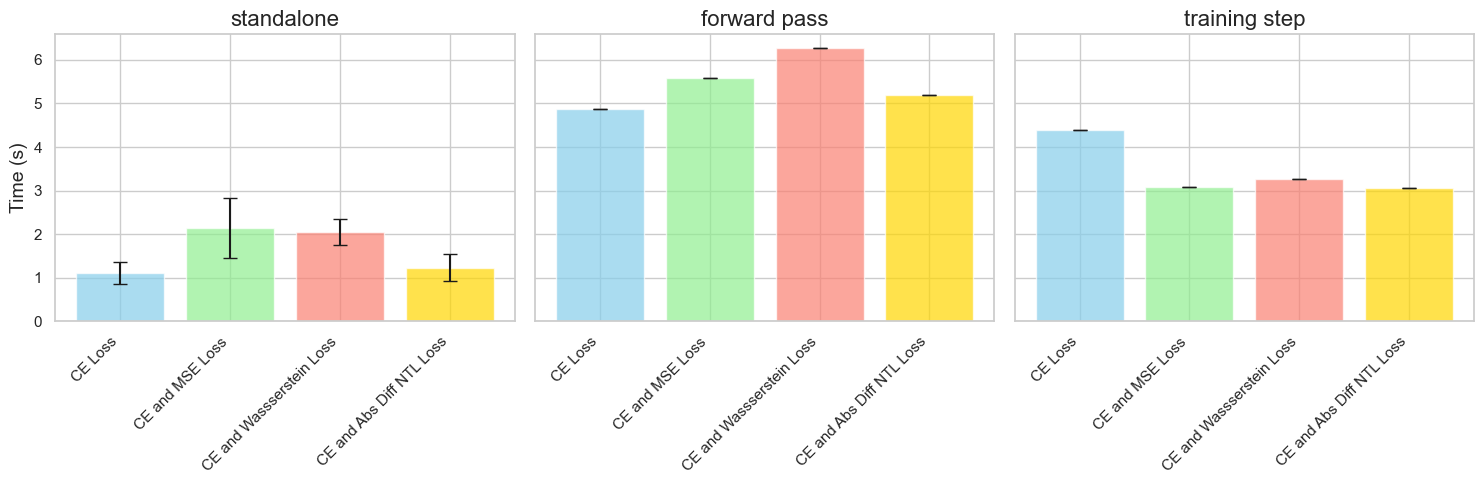

In [76]:
combined_plots(df_long)

In [84]:
def seperate_plots(df):
    # Unique benchmarks and loss functions
    benchmarks = df["benchmark"].unique()
    loss_functions = df["loss"].unique()

    # Define colors for each loss function
    colors = ["skyblue", "lightgreen", "salmon", "gold"]
    color_map = {loss: color for loss, color in zip(loss_functions, colors)}

    # Plot for each benchmark separately
    for benchmark in benchmarks:
        subset = df[df["benchmark"] == benchmark]
        
        # Bar positions and labels
        x = np.arange(len(subset))
        
        # Create the plot
        plt.figure(figsize=(10, 6))
        for j, (loss, mean_time, error) in enumerate(zip(subset["loss"], subset["mean_time"], subset["error"])):
            plt.bar(x[j], mean_time, yerr=error, capsize=5, color=color_map[loss], alpha=0.7, label=loss)
        
        # Customize plot
        #plt.xticks(x, subset["loss"], rotation=45, ha="right")
        plt.title(benchmark)
        plt.xlabel("Loss Function")
        plt.ylabel("Time (s)")
        plt.legend()
        
        # Show the plot
        plt.tight_layout()
        plt.show()


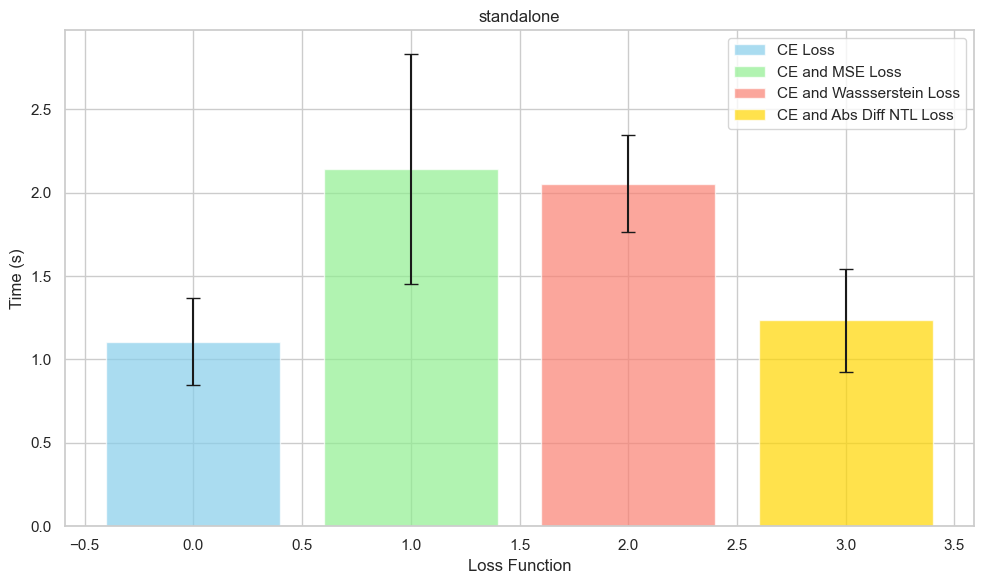

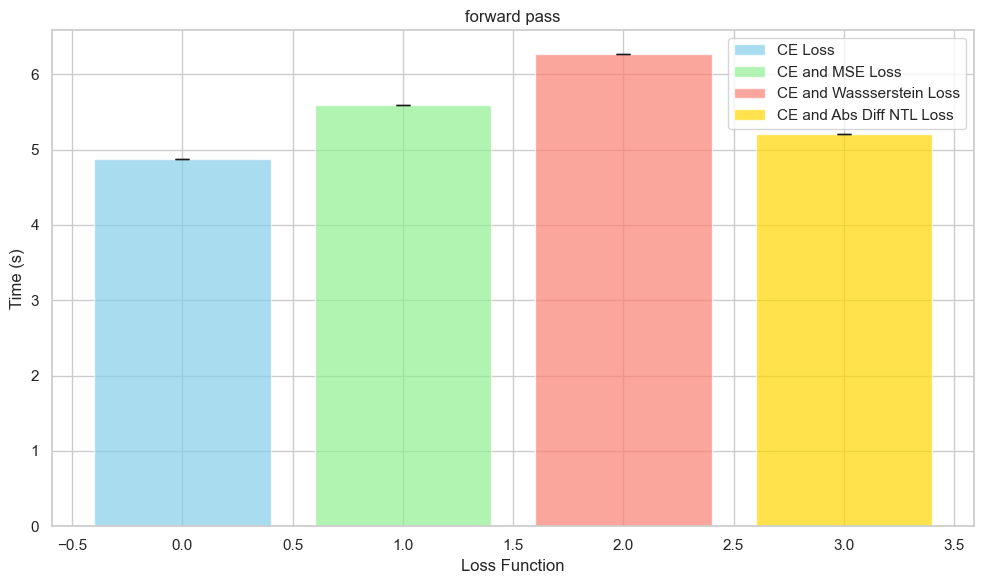

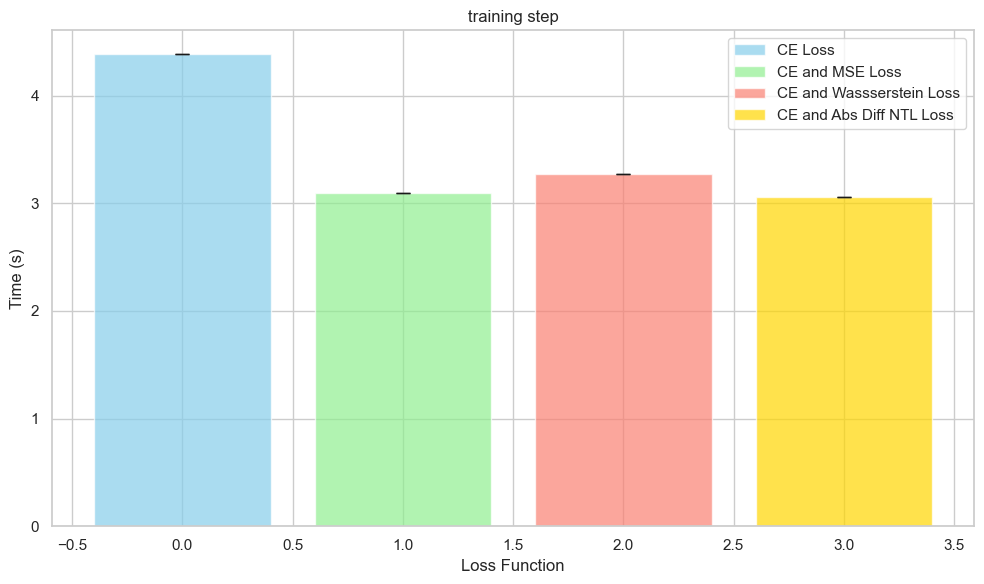

In [85]:
seperate_plots(df_long)

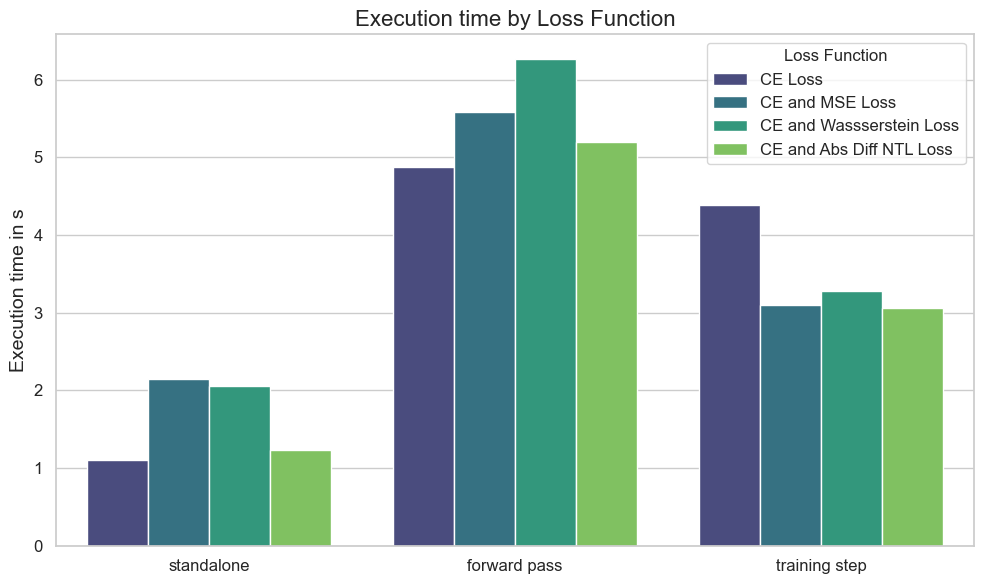

In [66]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data = df_long, x="benchmark", y="mean_time", hue="loss", palette="viridis")

# Customize the plot
plt.title("Execution time by Loss Function", fontsize=16)
plt.xlabel("", fontsize=14)
plt.ylabel("Execution time in s", fontsize=14)
plt.legend(title="Loss Function", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


## number share

In [24]:
df_30 = pd.read_csv('benchmark_results_173393181133.csv')
df_30 = df_30.melt(id_vars="loss", var_name="benchmark", value_name="time")
df_30['number_share'] = 30

df_60 = pd.read_csv('benchmark_results_173393229602.csv')
df_60 = df_60.melt(id_vars="loss", var_name="benchmark", value_name="time")
df_60['number_share'] = 60

df_90 = pd.read_csv('benchmark_results_173393274483.csv')
df_90 = df_90.melt(id_vars="loss", var_name="benchmark", value_name="time")
df_90['number_share'] = 90

In [25]:
df_combined = pd.concat([df_30, df_60, df_90])

In [26]:
df_combined.head()

,loss,benchmark,time,number_share
0,CE Loss,standalone,8.100021,30
1,MSE Loss,standalone,0.306356,30
2,Wassserstein Loss,standalone,3.801448,30
3,Abs Diff NTL Loss,standalone,0.133512,30
4,CE Loss,forward pass,36.983717,30


In [37]:
df_standalone = df_combined[df_combined['benchmark'] == 'standalone']
df_training = df_combined[df_combined['benchmark'] == 'training step']

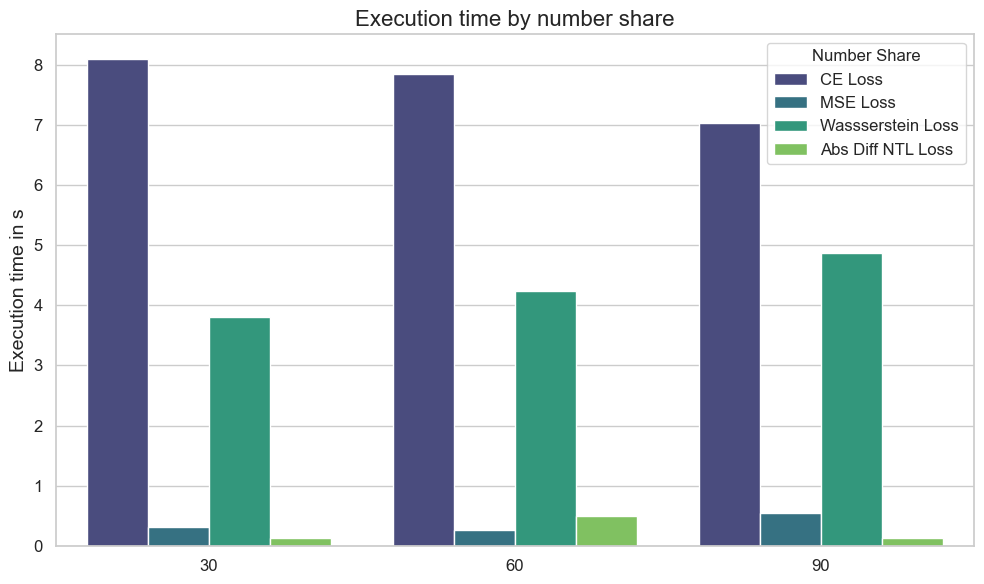

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data = df_standalone, x="number_share", y="time", hue="loss", palette="viridis")

# Customize the plot
plt.title("Execution time by number share", fontsize=16)
plt.xlabel("", fontsize=14)
plt.ylabel("Execution time in s", fontsize=14)
plt.legend(title="Number Share", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()


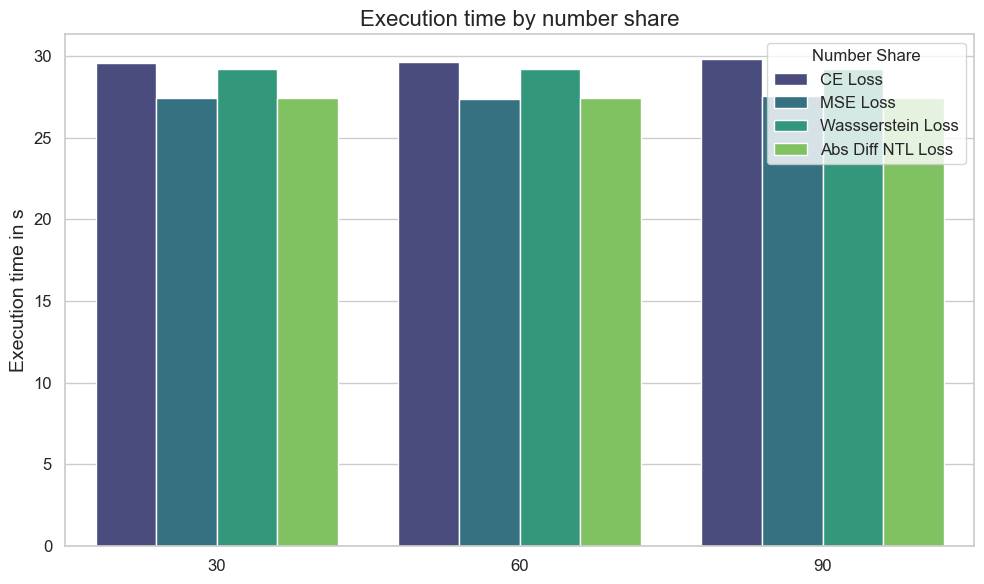

In [38]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set Seaborn style
sns.set(style="whitegrid")

# Create the bar plot
plt.figure(figsize=(10, 6))
sns.barplot(data = df_training, x="number_share", y="time", hue="loss", palette="viridis")

# Customize the plot
plt.title("Execution time by number share", fontsize=16)
plt.xlabel("", fontsize=14)
plt.ylabel("Execution time in s", fontsize=14)
plt.legend(title="Number Share", fontsize=12)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()

# Show the plot
plt.show()
